C:\Users\aseif\AppData\Local\Temp\ipykernel_22412\115693172.py:150: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(list(home_df["PLAYER"])+list(away_df["PLAYER"]), rotation=45, ha="right")


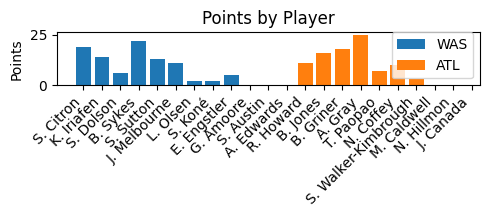

In [ ]:
import tkinter as tk
from tkinter import ttk, messagebox, filedialog
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
import time
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

# Data cleaning functions
def split_shooting_columns(df):
    for col in ['FGM-A', '3PM-A', 'FTM-A']:
        if col in df.columns:
            new_cols = df[col].str.split("-", expand=True)
            new_names = {'FGM-A': ['FGM', 'FGA'], '3PM-A': ['3PM', '3PA'], 'FTM-A': ['FTM', 'FTA']}
            df[new_names[col][0]] = new_cols[0]
            df[new_names[col][1]] = new_cols[1]
            df.drop(columns=[col], inplace=True)
    return df

def reorder_shooting_columns(df):
    shooting_cols = ["FGM", "FGA", "3PM", "3PA", "FTM", "FTA"]
    existing = [col for col in shooting_cols if col in df.columns]
    first_two = df.columns.tolist()[:2]
    rest = [col for col in df.columns if col not in first_two + existing]
    return df[first_two + existing + rest]

def get_cleaned_boxscores(game_id, home_abbr, away_abbr, game_date, game_time):
    url = f"https://www.wnba.com/game/{game_id}/{home_abbr}-vs-{away_abbr}/boxscore"
    options = Options()
    options.add_argument("--headless")
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")

    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)
    driver.get(url)
    time.sleep(5)

    soup = BeautifulSoup(driver.page_source, "html.parser")
    tables = soup.find_all("table")

    if len(tables) < 2:
        driver.quit()
        raise ValueError("Not enough tables found.")

    def parse_table(table):
        headers = [th.get_text(strip=True) for th in table.find_all("th")]
        rows = []
        for row in table.find("tbody").find_all("tr"):
            cells = [td.get_text(strip=True) for td in row.find_all("td")]
            if cells:
                rows.append(cells)
        return pd.DataFrame(rows, columns=headers)

    home_df = parse_table(tables[0])
    away_df = parse_table(tables[1])

    for df, team, opp, loc in [(home_df, home_abbr, away_abbr, "Home"), (away_df, away_abbr, home_abbr, "Away")]:
        df["Team"] = team
        df["Opponent"] = opp
        df["Location"] = loc
        df["Game Date"] = game_date
        df["Game Time"] = game_time
        df["Game ID"] = game_id

    home_df = reorder_shooting_columns(split_shooting_columns(home_df))
    away_df = reorder_shooting_columns(split_shooting_columns(away_df))

    driver.quit()
    return home_df, away_df

def show_data():
    global latest_df

    game_id = entry_game_id.get()
    home_abbr = entry_home.get()
    away_abbr = entry_away.get()
    game_date = entry_date.get()
    game_time = entry_time.get()

    try:
        home_df, away_df = get_cleaned_boxscores(game_id, home_abbr, away_abbr, game_date, game_time)
        latest_df = pd.concat([home_df, away_df], ignore_index=True)

        for widget in scrollable_table_frame.winfo_children():
            widget.destroy()

        create_team_tree(home_df, f"    {home_abbr} Boxscore")
        create_team_tree(away_df, f"    {away_abbr} Boxscore")

        btn_save.config(state="normal")
        display_stat_leaders_per_team()

        home_pts = pd.to_numeric(home_df["PTS"], errors="coerce").sum()
        away_pts = pd.to_numeric(away_df["PTS"], errors="coerce").sum()
        label_score.config(text=f"{home_abbr} {int(home_pts)} - {int(away_pts)} {away_abbr}", font=("Arial", 24, "bold"))

        display_graphs(home_df, away_df)

    except Exception as e:
        messagebox.showerror("Error", str(e))

def display_stat_leaders_per_team():
    if latest_df is None:
        return

    stat_columns = ["PTS", "REB", "AST", "STL", "BS", "TO", "+/-"]

    for label_dict in [summary_labels_home, summary_labels_away]:
        for label in label_dict.values():
            label.config(text="")

    for team in latest_df["Team"].unique():
        team_df = latest_df[latest_df["Team"] == team].copy()

        for stat in stat_columns:
            if stat in team_df.columns:
                team_df[stat] = pd.to_numeric(team_df[stat], errors="coerce")

        leaders = {}
        for stat in stat_columns:
            if stat in team_df.columns and team_df[stat].notna().any():
                max_index = team_df[stat].idxmax()
                leader_row = team_df.loc[max_index]
                player = leader_row.get("PLAYER", "Unknown")
                value = leader_row[stat]
                leaders[stat] = f"{stat}: {player} ({value})"

        is_home = team_df["Location"].iloc[0] == "Home"
        label_dict = summary_labels_home if is_home else summary_labels_away

        for i, stat in enumerate(stat_columns):
            if stat in leaders and stat in label_dict:
                label_dict[stat].config(text=leaders[stat])

def display_graphs(home_df, away_df):
    for widget in graph_frame.winfo_children():
        widget.destroy()

    fig1, ax1 = plt.subplots(figsize=(5, 3))
    home_pts = pd.to_numeric(home_df["PTS"], errors="coerce")
    away_pts = pd.to_numeric(away_df["PTS"], errors="coerce")
    ax1.bar(home_df["PLAYER"], home_pts, label=home_df["Team"].iloc[0])
    ax1.bar(away_df["PLAYER"], away_pts, label=away_df["Team"].iloc[0])
    ax1.set_title("Points by Player")
    ax1.set_ylabel("Points")
    ax1.set_xticklabels(list(home_df["PLAYER"])+list(away_df["PLAYER"]), rotation=45, ha="right")
    ax1.legend()
    fig1.tight_layout()
    canvas1 = FigureCanvasTkAgg(fig1, master=graph_frame)
    canvas1.get_tk_widget().pack(pady=5)

    stats = ["PTS", "REB", "AST", "STL", "BS", "TO"]
    home_totals = [pd.to_numeric(home_df[stat], errors="coerce").sum() for stat in stats]
    away_totals = [pd.to_numeric(away_df[stat], errors="coerce").sum() for stat in stats]

    fig2, ax2 = plt.subplots(figsize=(5, 3))
    bar_width = 0.35
    index = range(len(stats))
    ax2.bar(index, home_totals, bar_width, label=home_df["Team"].iloc[0])
    ax2.bar([i + bar_width for i in index], away_totals, bar_width, label=away_df["Team"].iloc[0])
    ax2.set_title("Team Stat Comparison")
    ax2.set_xticks([i + bar_width / 2 for i in index])
    ax2.set_xticklabels(stats)
    ax2.legend()
    fig2.tight_layout()
    canvas2 = FigureCanvasTkAgg(fig2, master=graph_frame)
    canvas2.get_tk_widget().pack(pady=5)

def create_team_tree(df, label_text):
    lbl = tk.Label(scrollable_table_frame, text=label_text, font=("Arial", 10, "bold"), anchor="w")
    lbl.pack(fill="x", padx=10, pady=(5, 0))

    frame = tk.Frame(scrollable_table_frame)
    frame.pack(fill="both", expand=True, pady=2)

    tree = ttk.Treeview(frame, show='headings', height=8)
    tree["columns"] = list(df.columns)
    for col in df.columns:
        tree.heading(col, text=col)
        tree.column(col, width=80, anchor="center")

    for i in df.index:
        tree.insert("", "end", values=list(df.loc[i]))

    vsb = tk.Scrollbar(frame, orient="vertical", command=tree.yview)
    hsb = tk.Scrollbar(frame, orient="horizontal", command=tree.xview)
    tree.configure(yscrollcommand=vsb.set, xscrollcommand=hsb.set)

    tree.grid(row=0, column=0, sticky="nsew")
    vsb.grid(row=0, column=1, sticky="ns")
    hsb.grid(row=1, column=0, sticky="ew")
    frame.grid_columnconfigure(0, weight=1)
    frame.grid_rowconfigure(0, weight=1)

# --- GUI Setup ---
root = tk.Tk()
root.title("WNBA Boxscore Viewer")

frame_inputs = tk.Frame(root)
frame_inputs.pack(pady=10)

input_labels = ["Game ID", "Home Abbr", "Away Abbr", "Game Date", "Game Time"]
entry_vars = []

for i, label in enumerate(input_labels):
    tk.Label(frame_inputs, text=label).grid(row=i, column=0, sticky="e", padx=5)
    entry = tk.Entry(frame_inputs)
    entry.grid(row=i, column=1, padx=5)
    entry_vars.append(entry)

entry_game_id, entry_home, entry_away, entry_date, entry_time = entry_vars

btn_fetch = tk.Button(frame_inputs, text="Fetch Boxscore", command=show_data)
btn_fetch.grid(row=len(input_labels), column=0, columnspan=2, pady=5)

btn_save = tk.Button(frame_inputs, text="Save to CSV", command=lambda: None, state="disabled")
btn_save.grid(row=len(input_labels)+1, column=0, columnspan=2, pady=5)

label_score = tk.Label(root, text="", font=("Arial", 16, "bold"), fg="blue")
label_score.pack(pady=5)

# Scrollable table section
container = tk.Frame(root)
container.pack(fill="both", expand=True)

canvas = tk.Canvas(container)
x_scrollbar = tk.Scrollbar(container, orient="horizontal", command=canvas.xview)
y_scrollbar = tk.Scrollbar(container, orient="vertical", command=canvas.yview)
canvas.configure(xscrollcommand=x_scrollbar.set, yscrollcommand=y_scrollbar.set)

x_scrollbar.pack(side="bottom", fill="x")
y_scrollbar.pack(side="right", fill="y")
canvas.pack(side="left", fill="both", expand=True)

scrollable_table_frame = tk.Frame(canvas)
canvas.create_window((0, 0), window=scrollable_table_frame, anchor="nw")
scrollable_table_frame.bind("<Configure>", lambda e: canvas.configure(scrollregion=canvas.bbox("all")))

# Stat Leaders Summary
summary_title = tk.Label(root, text="Stat Leaders Summary", font=("Arial", 12, "bold"))
summary_title.pack(pady=3)

frame_summary = tk.Frame(root)
frame_summary.pack(pady=5, fill="x")

frame_summary_home = tk.LabelFrame(frame_summary, text="Home Leaders", padx=5, pady=3)
frame_summary_home.pack(side="left", expand=True, fill="x", padx=5)

frame_summary_away = tk.LabelFrame(frame_summary, text="Away Leaders", padx=5, pady=3)
frame_summary_away.pack(side="left", expand=True, fill="x", padx=5)

summary_stats = ["PTS", "REB", "AST", "STL", "BS", "TO", "+/-"]
summary_labels_home = {stat: tk.Label(frame_summary_home, text="", font=("Arial", 8), anchor="center") for stat in summary_stats}
summary_labels_away = {stat: tk.Label(frame_summary_away, text="", font=("Arial", 8), anchor="center") for stat in summary_stats}

for i, stat in enumerate(summary_stats):
    summary_labels_home[stat].grid(row=i, column=0, sticky="nsew", pady=1)
    summary_labels_away[stat].grid(row=i, column=0, sticky="nsew", pady=1)

frame_summary_home.grid_columnconfigure(0, weight=1)
frame_summary_away.grid_columnconfigure(0, weight=1)

# Graph Frame
graph_frame = tk.Frame(root)
graph_frame.pack(pady=10, fill="x")

latest_df = None
root.mainloop()
